In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

## Helper Functions Explanation

I created several helper functions to streamline the data processing, analysis, and model evaluation steps. as they are reusable, and easier to understand.

### 1. `handle_missing_values`

 Handles missing values in the dataset using a specified strategy.
- **Parameters**:
  - `df`: The DataFrame to process.
  - `strategy`: Either `'drop'` to remove columns with too many missing values or `'impute'` to fill missing values with specific values.
  - `threshold`: The proportion of missing values (e.g., 0.4 or 40%) above which columns are dropped (used with `'drop'` strategy).
  - `impute_dict`: A dictionary specifying column names and values to fill in missing data (used with `'impute'` strategy).

### 2. `binary_map`

Converts binary categorical values ('Yes'/'No') to numerical values (1/0).
- **Parameters**:
  - `x`: A Series or DataFrame column with 'Yes' or 'No' values.


### 3. `plot_univariate`

Generates plots to analyze the distribution of a single column.
- **Parameters**:
  - `df`: The DataFrame containing the data.
  - `column`: The column to plot.
  - `kind`: The plot type—`'count'` for categorical variables or `'box'` for numerical variables.

### 4. `plot_bivariate`
Plots a specified column against the target variable to explore their relationship.
- **Parameters**:
  - `df`: The DataFrame containing the data.
  - `column`: The column to plot.
  - `target`: The target variable (default is `'Converted'`).
  - `kind`: The plot type—`'count'` for categorical variables or `'box'` for numerical variables.

### 5. `cap_outliers`

Caps outliers in numerical columns at specified percentiles.

- **Parameters**:
  - `df`: The DataFrame containing the data.
  - `column`: The column to cap outliers in.
  - `lower_percentile`: The lower bound .
  - `upper_percentile`: The upper bound .

### 6. `evaluate_model`

Evaluates model performance using various metrics.
- **Parameters**:
  - `y_true`: The true labels.
  - `y_pred`: The predicted labels.
  - `y_prob`: The predicted probabilities (optional, for ROC AUC).

In [ ]:

# Handle the missing values
def handle_missing_values(df, strategy='drop', threshold=0.4, impute_dict=None):

    if strategy == 'drop':
        df = df.loc[:, df.isnull().mean() < threshold]
    if strategy == 'impute' and impute_dict:
        for col, value in impute_dict.items():
            df[col] = df[col].fillna(value)
    return df

def binary_map(x):
    return x.map({'Yes': 1, 'No': 0})

def plot_univariate(df, column, kind='count'):
    plt.figure(figsize=(10, 5))
    if kind == 'count':
        sns.countplot(x=column, data=df)
        plt.xticks(rotation=90)
    elif kind == 'box':
        sns.boxplot(y=column, data=df, orient='v')
    plt.title(f'Univariate Analysis: {column}')
    plt.show()

def plot_bivariate(df, column, target='Converted', kind='count'):
    plt.figure(figsize=(10, 5))
    if kind == 'count':
        sns.countplot(x=column, hue=target, data=df, palette='Set1')
        plt.xticks(rotation=90)
    elif kind == 'box':
        sns.boxplot(y=column, x=target, data=df, palette='Set1')
    plt.title(f'Bivariate Analysis: {column} vs {target}')
    plt.show()

def cap_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    percentiles = df[column].quantile([lower_percentile, upper_percentile]).values
    df[column] = np.clip(df[column], percentiles[0], percentiles[1])
    return df

def evaluate_model(y_true, y_pred, y_prob=None):
    confusion = metrics.confusion_matrix(y_true, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    metrics_dict = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Sensitivity': TP / float(TP + FN),
        'Specificity': TN / float(TN + FP),
        'Precision': TP / float(TP + FP),
        'Recall': TP / float(TP + FN)
    }

    if y_prob is not None:
        metrics_dict['ROC AUC'] = metrics.roc_auc_score(y_true, y_prob)

    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.3f}")
    return metrics_dict



In [ ]:
# Load the dataset
lead_data = pd.read_csv("Leads.csv")
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [ ]:

# --- Data Exploration ---
# Check the shape of the data
print("Shape of the data:", lead_data.shape)

Shape of the data: (9240, 37)


In [ ]:

# Check data types and non-null counts
print("\nData Info:")
lead_data.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                    

In [ ]:
# Describe numerical columns
print("\nData Description:")
print(lead_data.describe())



Data Description:
         Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000  

In [ ]:

# --- Data Cleaning ---
# Replace 'Select' with NaN as it represents an unselected option (equivalent to null)
lead_data = lead_data.replace('Select', np.nan)

In [ ]:

# Check missing values
print("\nMissing Values:")
print(lead_data.isnull().sum())


Missing Values:
Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper A

In [ ]:
# Calculate missing value percentages
missing_percentages = round(lead_data.isnull().mean() * 100, 2)
print("\nMissing Value Percentages:")
print(missing_percentages)


Missing Value Percentages:
Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                             

In [ ]:
# Drop columns with missing values >= 40%
lead_data = handle_missing_values(lead_data, strategy='drop', threshold=0.4)

In [ ]:

# Define imputation strategy for remaining columns with missing values
impute_dict = {
    'Specialization': 'Others',  # Missing likely due to no specialization or not listed
    'Tags': 'Will revert after reading the email',  # Most frequent value
    'What is your current occupation': 'Unemployed',  # Most frequent value
    'Country': 'India',  # Most frequent value
    'City': 'Mumbai'  # Most frequent value
}
lead_data = handle_missing_values(lead_data, strategy='impute', impute_dict=impute_dict)

In [ ]:

# Drop rows with remaining missing values (less than 2%)
lead_data.dropna(inplace=True)

In [ ]:

# Verify no missing values remain
print("\nMissing Values After Handling:")
print(lead_data.isnull().sum())



Missing Values After Handling:
Prospect ID                                      0
Lead Number                                      0
Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
Specialization                                   0
What is your current occupation                  0
What matters most to you in choosing a course    0
Search                                           0
Magazine                                         0
Newspaper Article                                0
X Education Forums                               0

In [ ]:

# Calculate percentage of rows retained
rows_retained = (len(lead_data) / 9240) * 100
print(f"\nPercentage of Rows Retained: {rows_retained:.2f}%")


Percentage of Rows Retained: 68.96%


In [ ]:

# Check for duplicates
print("\nNumber of Duplicate Rows:", len(lead_data[lead_data.duplicated()]))


Number of Duplicate Rows: 0


In [ ]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6372 entries, 0 to 9239
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    6372 non-null   object 
 1   Lead Number                                    6372 non-null   int64  
 2   Lead Origin                                    6372 non-null   object 
 3   Lead Source                                    6372 non-null   object 
 4   Do Not Email                                   6372 non-null   object 
 5   Do Not Call                                    6372 non-null   object 
 6   Converted                                      6372 non-null   int64  
 7   TotalVisits                                    6372 non-null   float64
 8   Total Time Spent on Website                    6372 non-null   int64  
 9   Page Views Per Visit                           6372 non-n

In [ ]:

# --- Exploratory Data Analysis (EDA) ---
# Conversion rate
conversion_rate = (lead_data['Converted'].sum() / len(lead_data)) * 100
print(f"\nLead Conversion Rate: {conversion_rate:.2f}%")


Lead Conversion Rate: 48.10%


In [ ]:

# Univariate and Bivariate Analysis
categorical_vars = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
                    'Last Activity', 'Country', 'Specialization',
                    'What is your current occupation', 'City', 'Last Notable Activity']
numerical_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

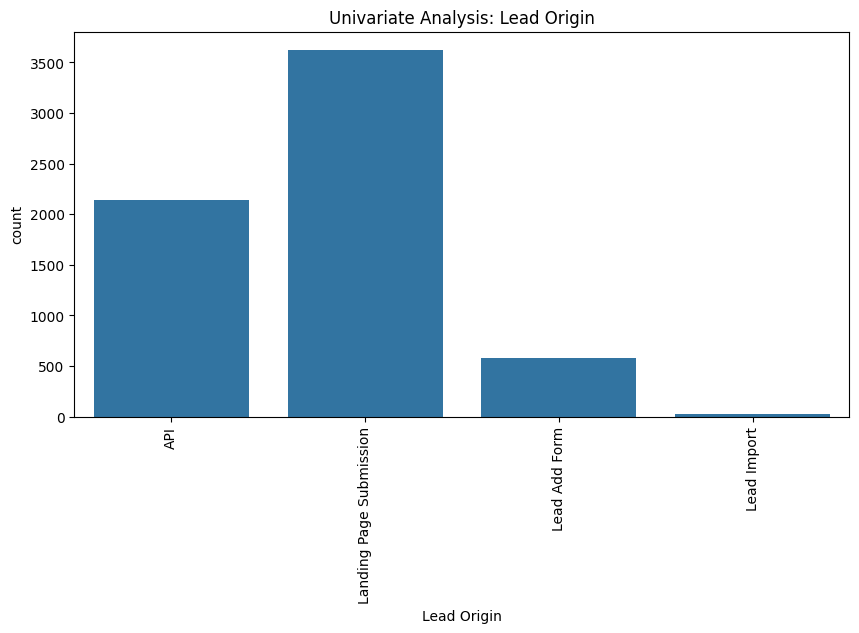

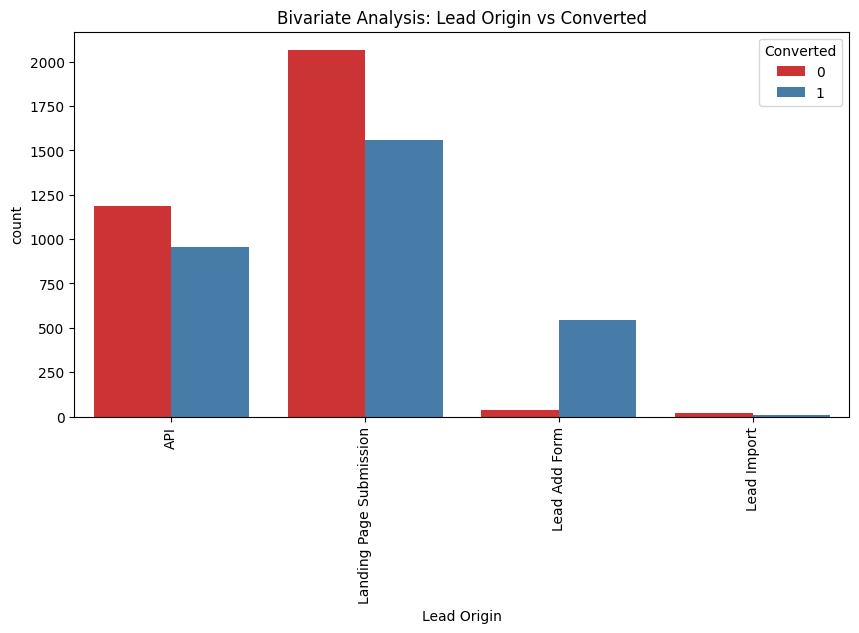

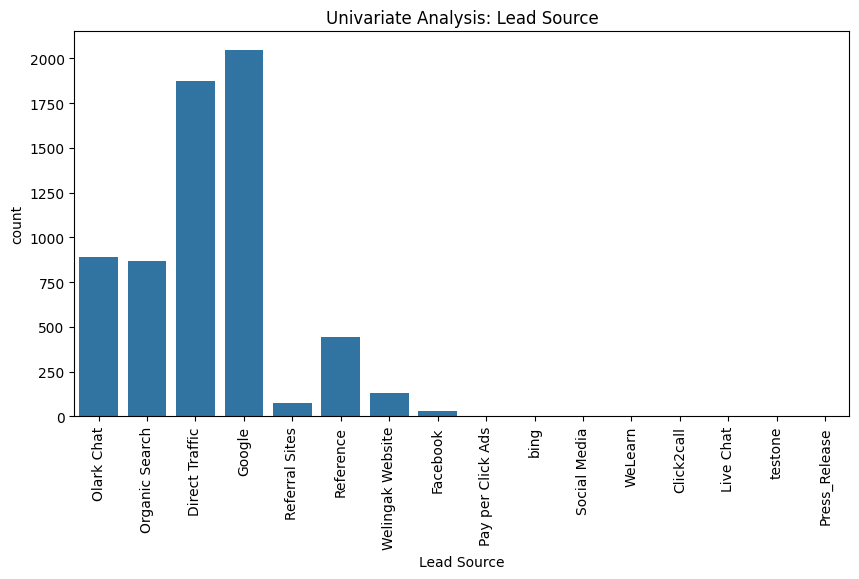

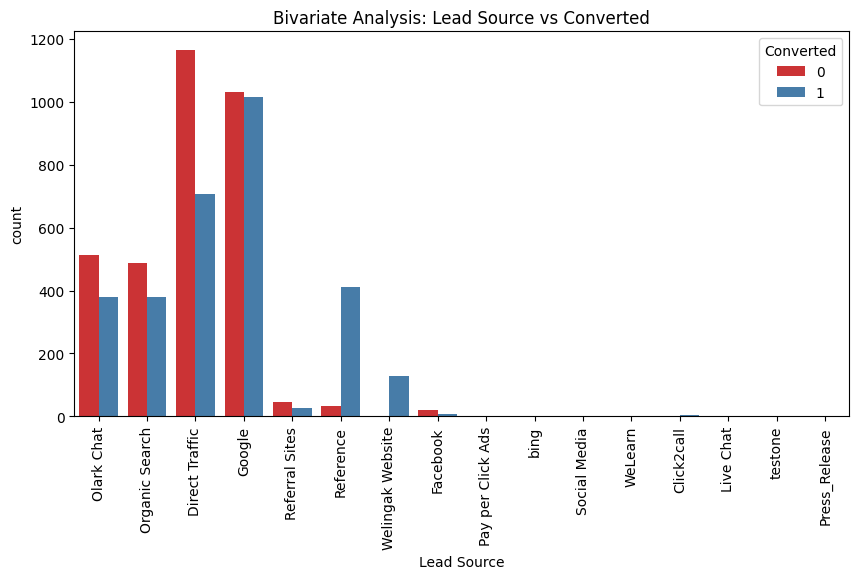

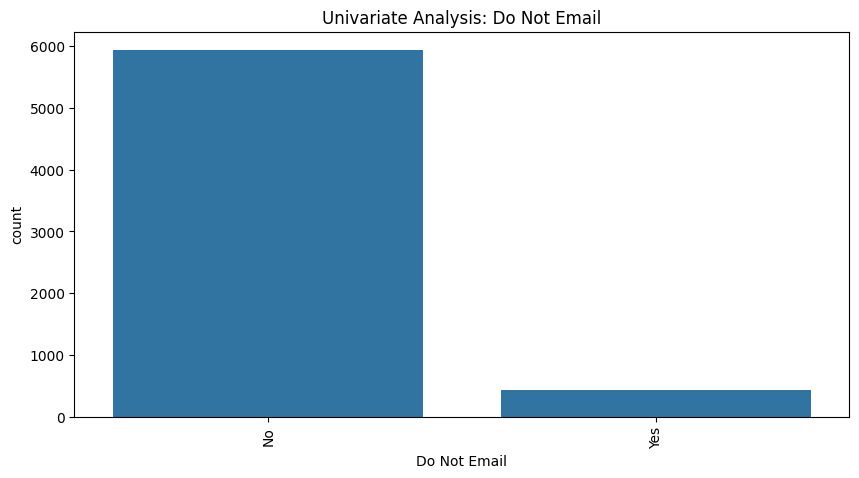

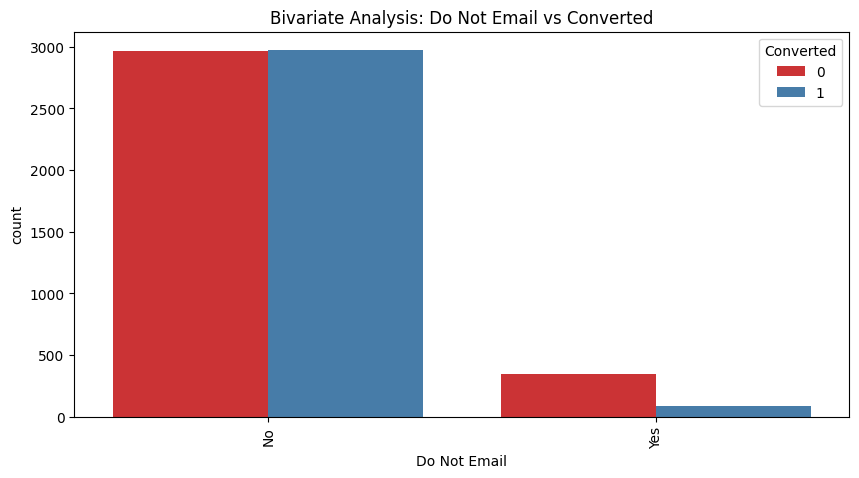

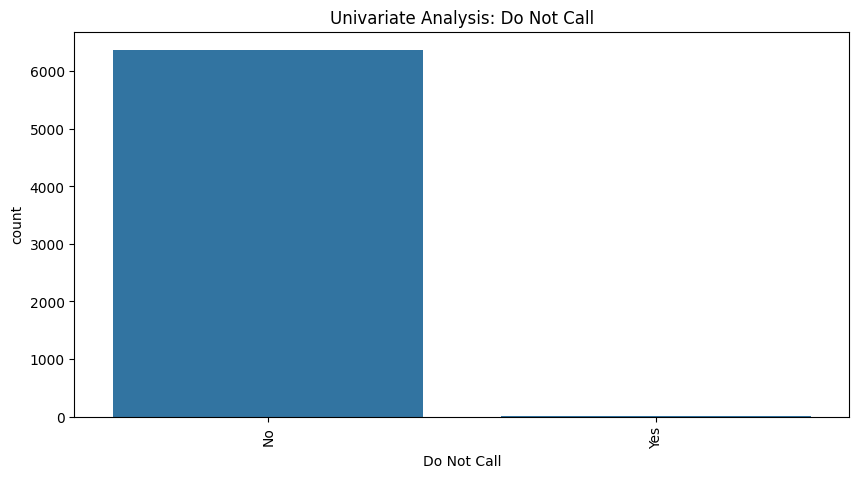

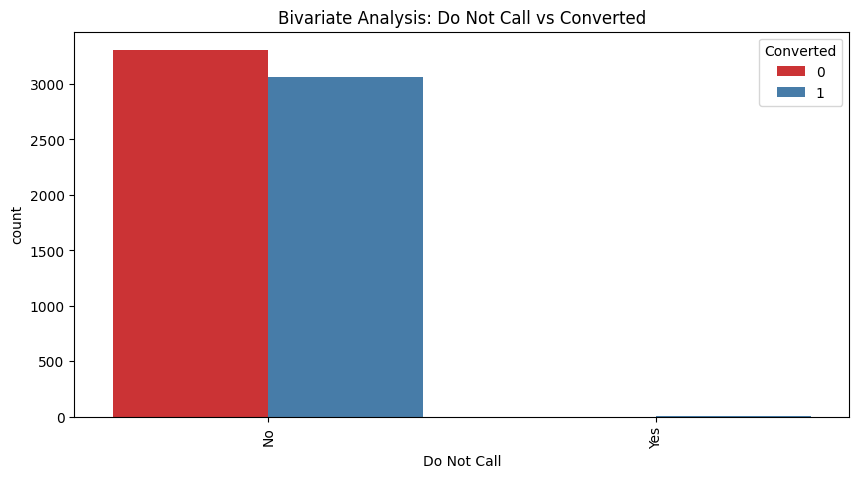

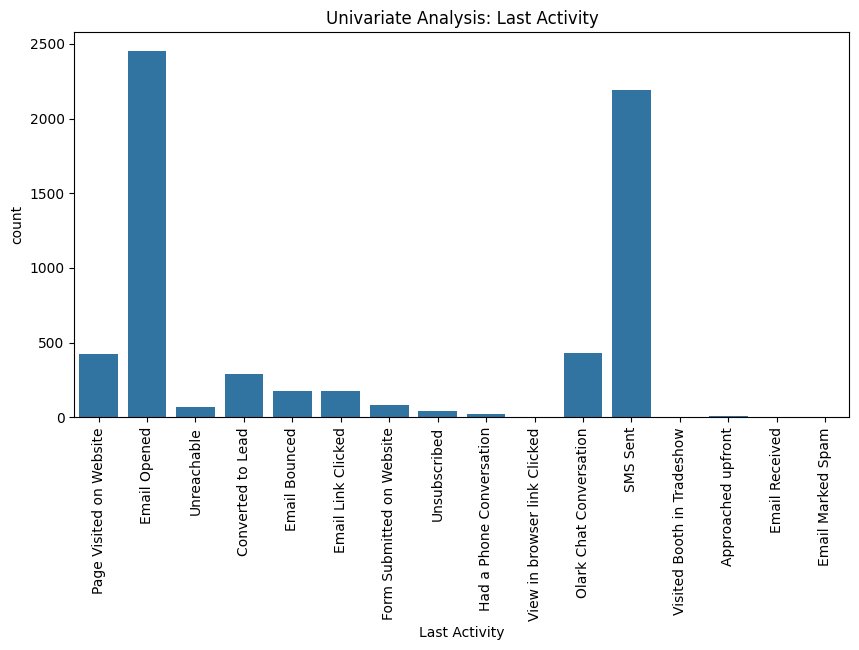

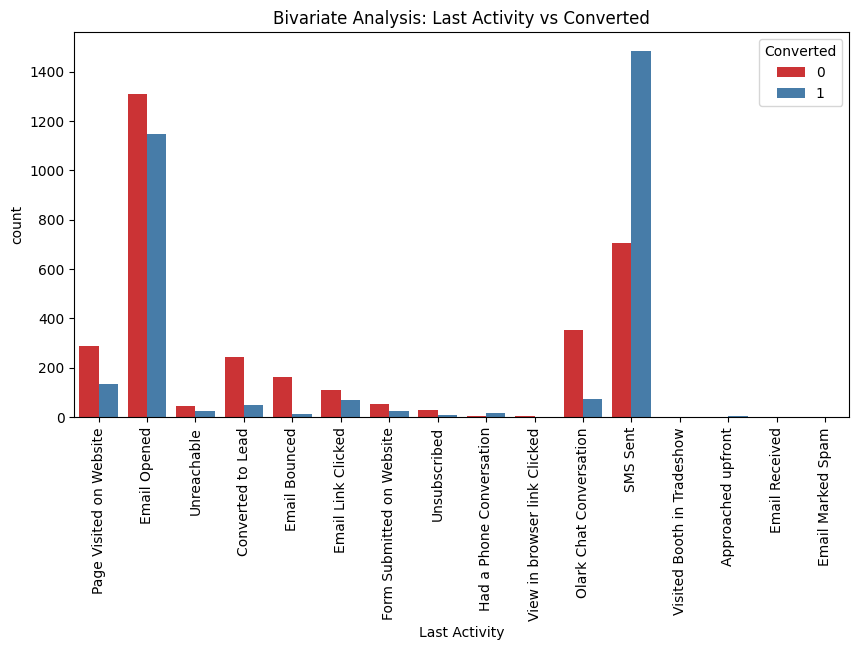

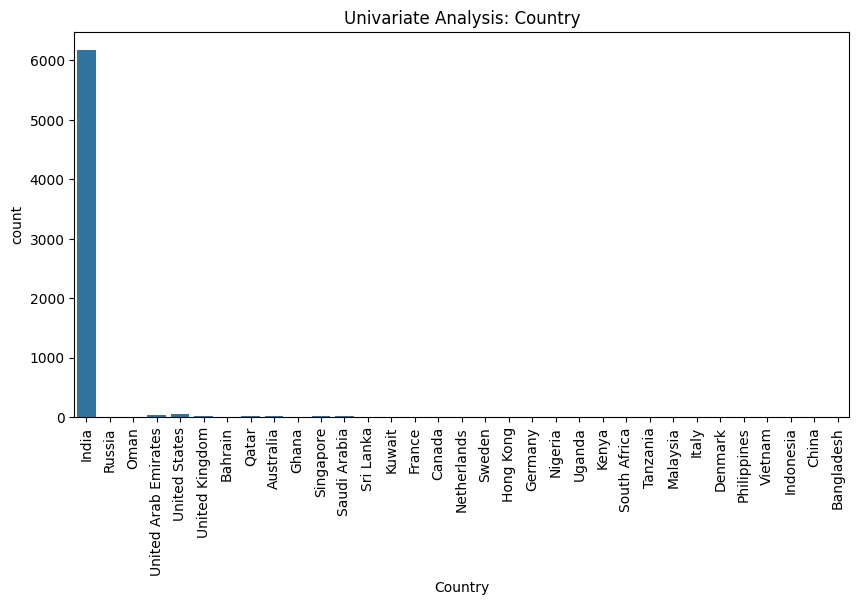

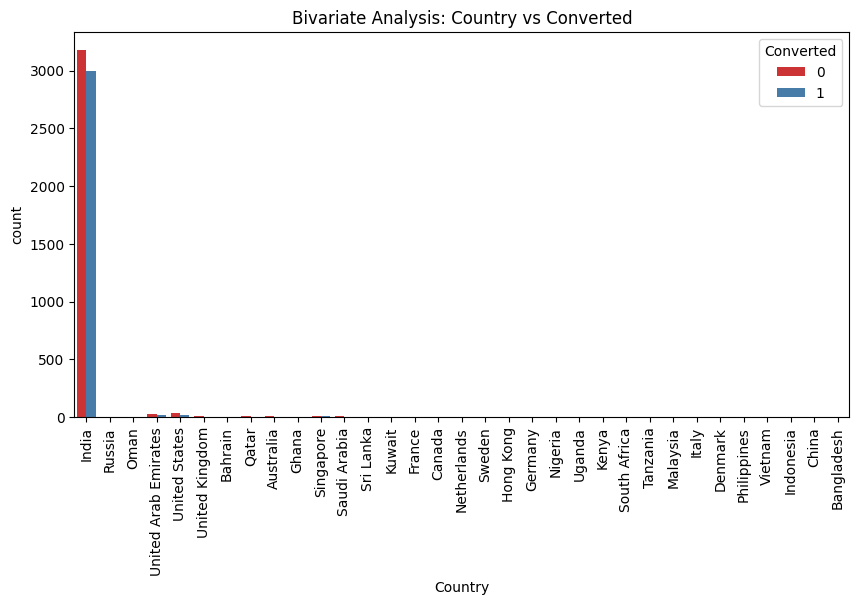

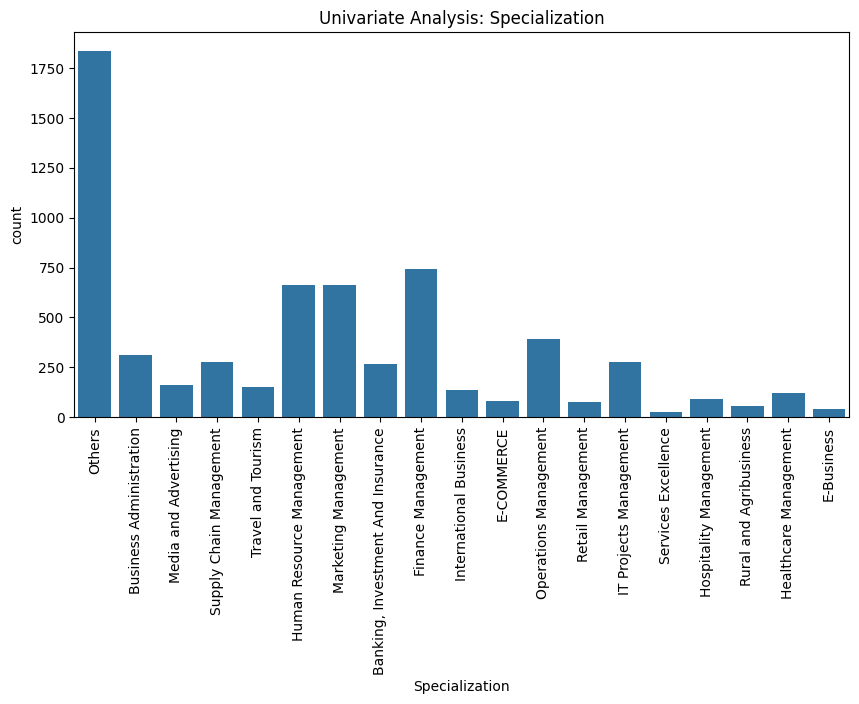

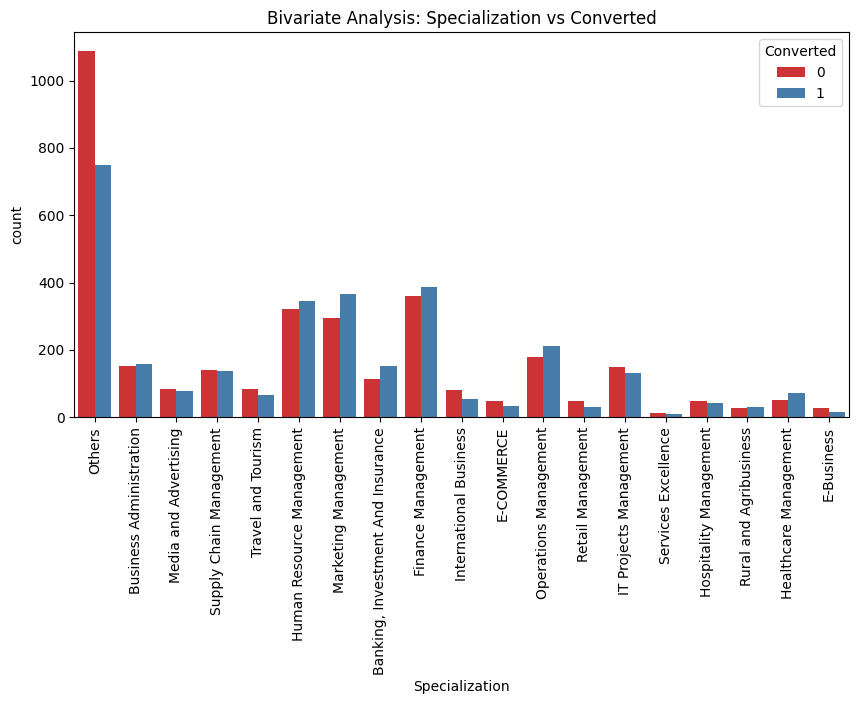

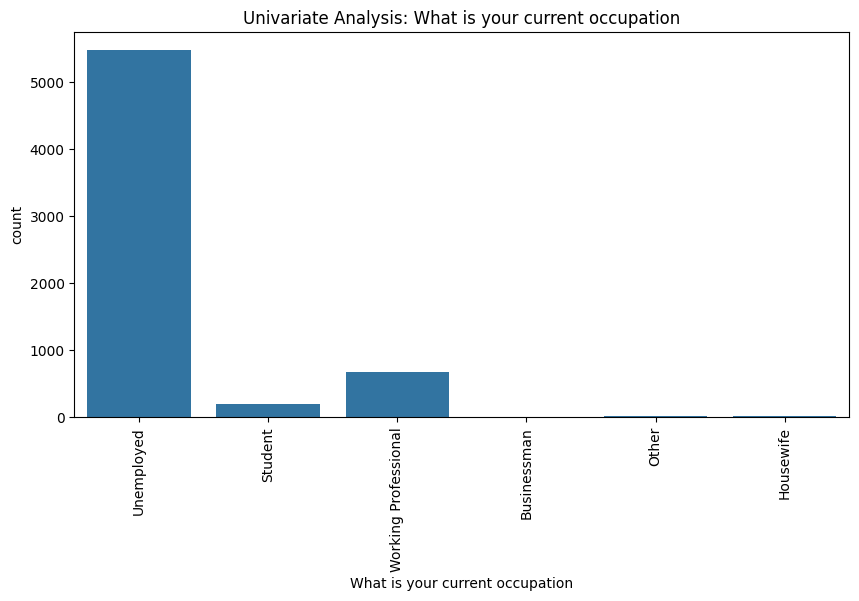

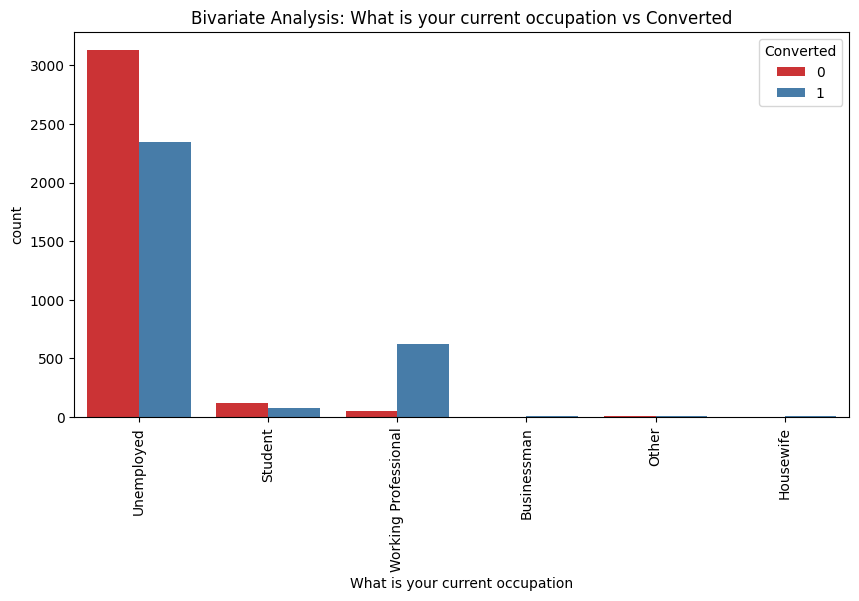

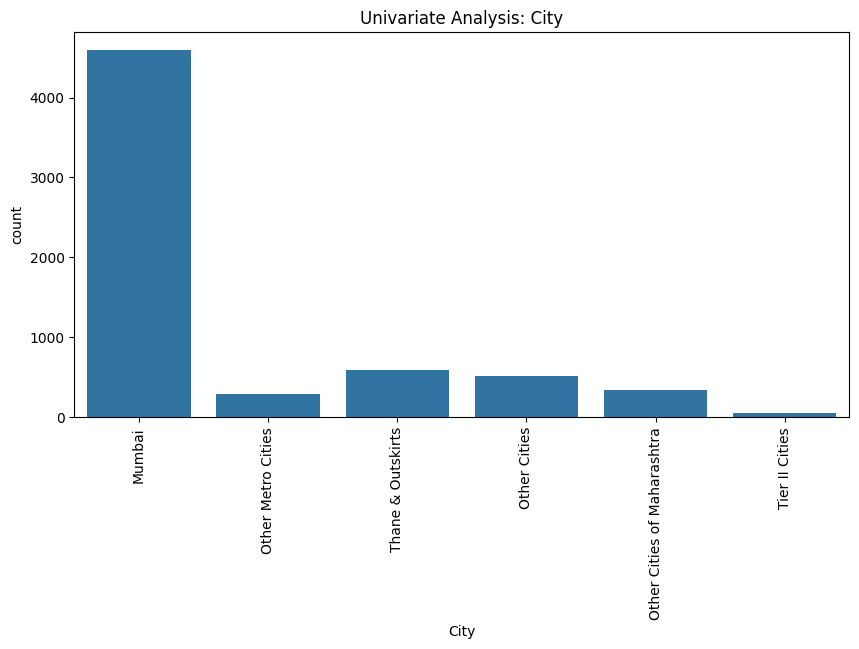

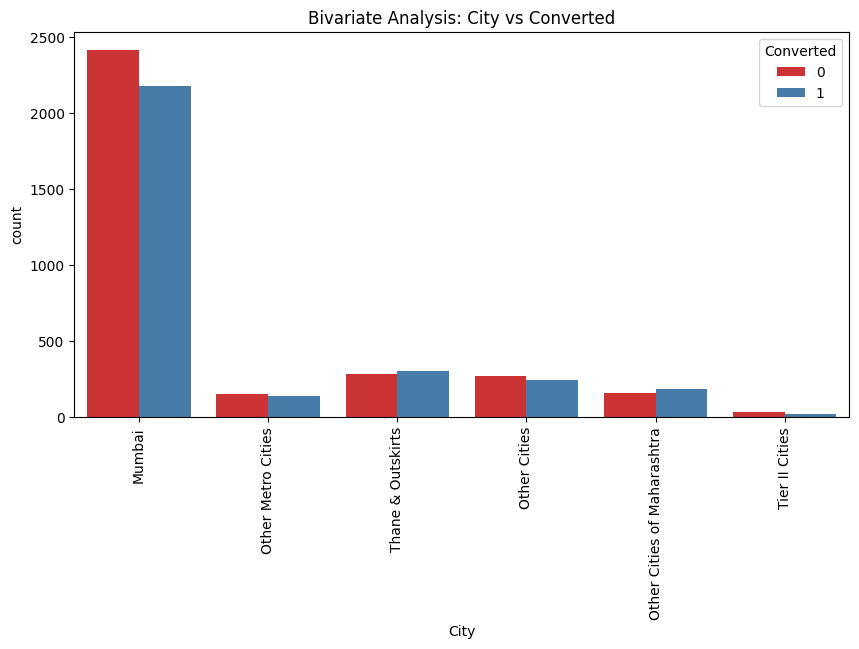

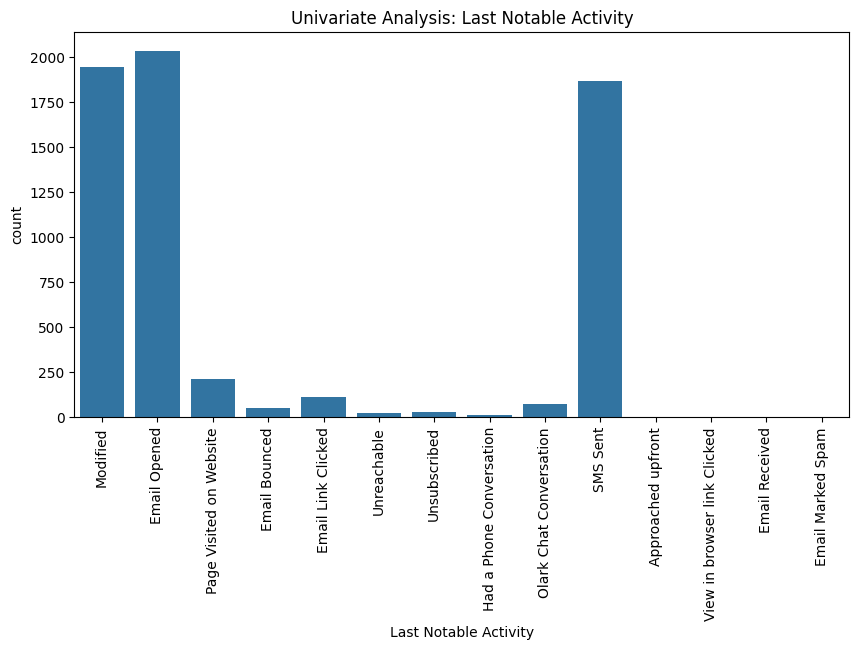

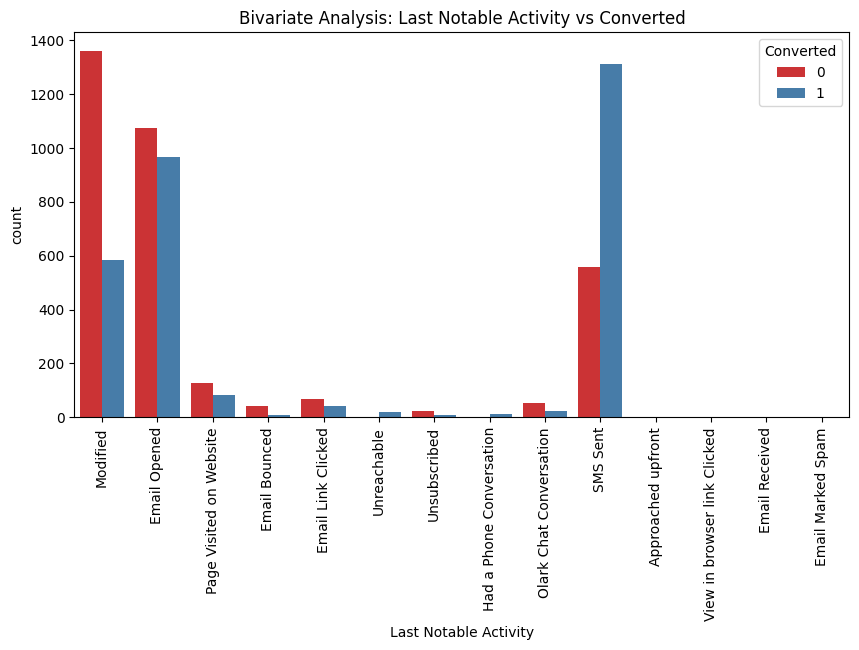

In [ ]:
# Plot categorical variables
for var in categorical_vars:
    plot_univariate(lead_data, var, kind='count')
    plot_bivariate(lead_data, var, kind='count')

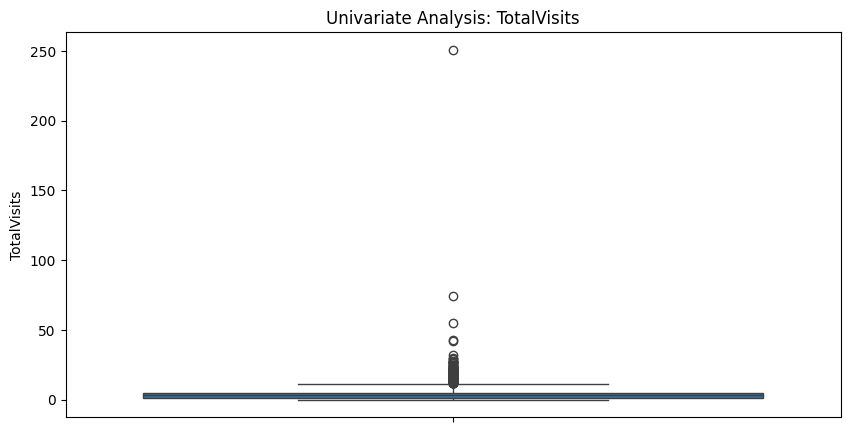

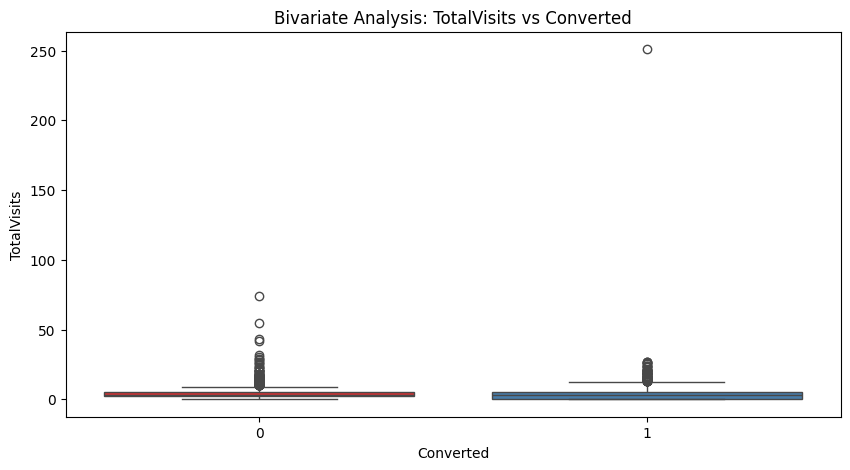

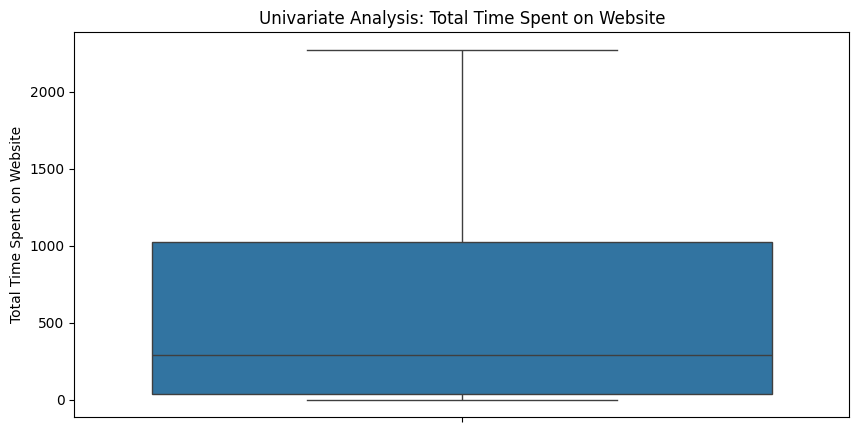

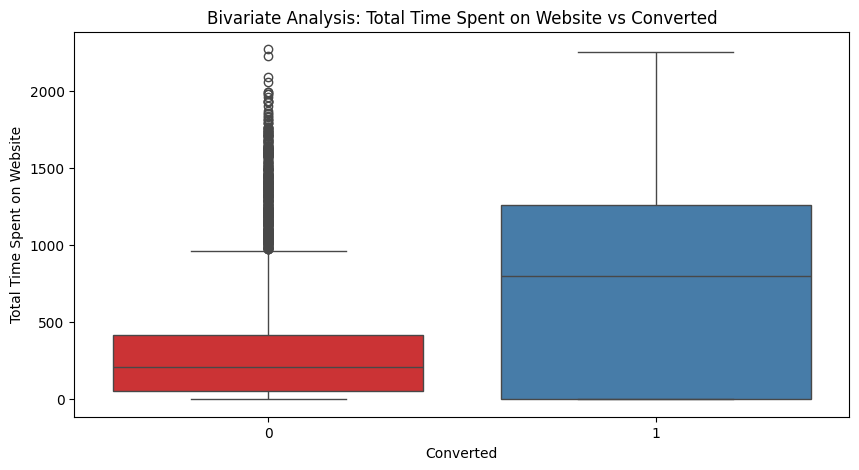

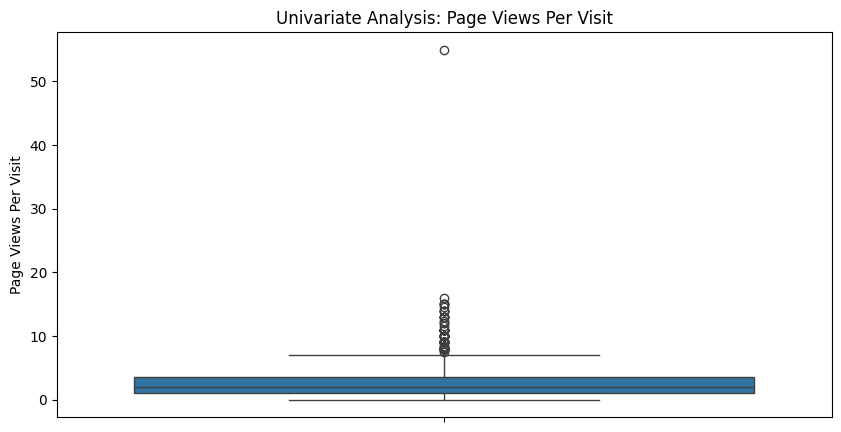

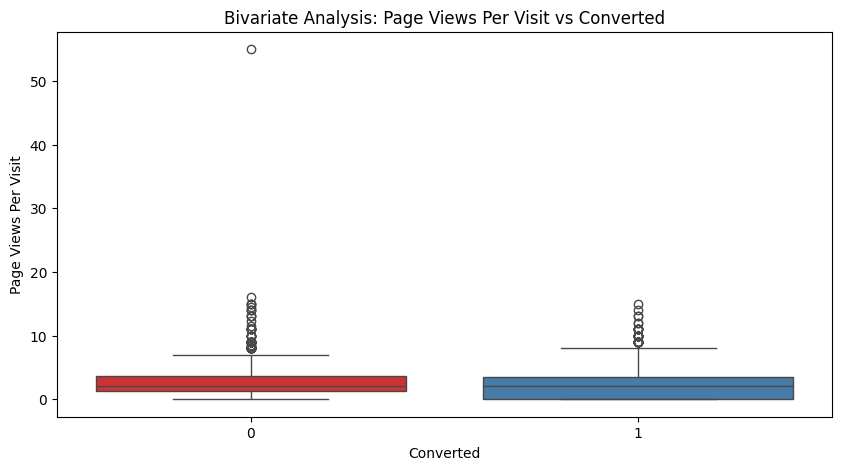

In [ ]:
# Plot numerical variables
for var in numerical_vars:
    plot_univariate(lead_data, var, kind='box')
    plot_bivariate(lead_data, var, kind='box')

In [ ]:
# Handle outliers in numerical variables
for var in ['TotalVisits', 'Page Views Per Visit']:
    lead_data = cap_outliers(lead_data, var)

In [ ]:

# Drop columns that add little information based on EDA
columns_to_drop = ['Lead Number', 'Tags', 'Country', 'Search', 'Magazine', 'Newspaper Article',
                   'X Education Forums', 'Newspaper', 'Digital Advertisement',
                   'Through Recommendations', 'Receive More Updates About Our Courses',
                   'Update me on Supply Chain Content', 'Get updates on DM Content',
                   'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']
lead_data = lead_data.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
# --- Data Preparation ---
# Convert binary variables to 1/0
binary_vars = ['Do Not Email', 'Do Not Call']
lead_data[binary_vars] = lead_data[binary_vars].apply(binary_map)


In [ ]:
# Create dummy variables for categorical features
categorical_features = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
                        'What is your current occupation', 'City', 'Last Notable Activity']
dummy_data = pd.get_dummies(lead_data[categorical_features], drop_first=True)
lead_data = pd.concat([lead_data, dummy_data], axis=1)
lead_data = lead_data.drop(categorical_features, axis=1)

In [ ]:

# Split data into features and target
X = lead_data.drop(['Prospect ID', 'Converted'], axis=1)
y = lead_data['Converted']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [ ]:

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_vars] = scaler.fit_transform(X_train[numerical_vars])
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])

In [ ]:
# --- Feature Selection ---
# Convert categorical column to dummy variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Use RFE to select top 20 features
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=20)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("\nFeatures selected by RFE:")
print(selected_features)


Features selected by RFE:
Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Source_Olark Chat', 'Lead Source_Reference',
       'Lead Source_Welingak Website',
       'Last Activity_Had a Phone Conversation', 'Last Activity_SMS Sent',
       'Specialization_Hospitality Management', 'Specialization_Others',
       'Specialization_Services Excellence',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable'],
      dtype='object')


In [ ]:

# --- Model Building ---
# Build initial model with selected features
X_train_sm = sm.add_constant(X_train[selected_features].astype(float))
logm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
res = logm.fit()
print("\nInitial Model Summary:")
print(res.summary())


Initial Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 4460
Model:                            GLM   Df Residuals:                     4439
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2014.3
Date:                Fri, 14 Mar 2025   Deviance:                       4028.6
Time:                        07:54:10   Pearson chi2:                 4.59e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3821
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:

# Convert boolean columns to integers
X_train = X_train.astype(int)

# Iteratively remove features with high p-values (> 0.05) or high VIF (> 5)
while True:
    # Check p-values
    p_values = res.pvalues
    if p_values.max() > 0.05:
        feature_to_remove = p_values.idxmax()
        selected_features = selected_features.drop(feature_to_remove)
        X_train_sm = sm.add_constant(X_train[selected_features].astype(float))
        logm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
        res = logm.fit()
    else:
        break

# Check VIF
vif = pd.DataFrame()
vif['Features'] = selected_features
vif['VIF'] = [variance_inflation_factor(X_train[selected_features].values, i) for i in range(len(selected_features))]
vif = vif.sort_values(by='VIF', ascending=False)
print("\nVIF Values:")
print(vif)



VIF Values:
                                      Features       VIF
12  What is your current occupation_Unemployed  6.345586
2          Lead Origin_Landing Page Submission  4.415083
9                        Specialization_Others  2.873778
7                       Last Activity_SMS Sent  1.599312
3                       Lead Source_Olark Chat  1.584246
13              Last Notable Activity_Modified  1.506771
1                  Total Time Spent on Website  1.290327
4                        Lead Source_Reference  1.195323
11     What is your current occupation_Student  1.190450
5                 Lead Source_Welingak Website  1.124631
0                                 Do Not Email  1.097758
8        Specialization_Hospitality Management  1.019318
10          Specialization_Services Excellence  1.008280
14           Last Notable Activity_Unreachable  1.006907
6       Last Activity_Had a Phone Conversation  1.006446


In [ ]:

while vif['VIF'].max() > 5:
    feature_to_remove = vif.iloc[0]['Features']
    selected_features = selected_features.drop(feature_to_remove)
    X_train_sm = sm.add_constant(X_train[selected_features].astype(float))
    logm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
    res = logm.fit()
    vif = pd.DataFrame()
    vif['Features'] = selected_features
    vif['VIF'] = [variance_inflation_factor(X_train[selected_features].values, i) for i in range(len(selected_features))]
    vif = vif.sort_values(by='VIF', ascending=False)

# Final model
print("\nFinal Selected Features:")
print(selected_features)
print("\nFinal Model Summary:")
print(res.summary())


Final Selected Features:
Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Had a Phone Conversation', 'Last Activity_SMS Sent',
       'Specialization_Hospitality Management', 'Specialization_Others',
       'Specialization_Services Excellence',
       'What is your current occupation_Student',
       'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable'],
      dtype='object')

Final Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 4460
Model:                            GLM   Df Residuals:                     4445
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                

In [ ]:

# --- Model Evaluation on Training Set ---
# Predict on training set
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'Converted': y_train.values, 'Converted_prob': y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final['Converted_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [ ]:

# Evaluate initial predictions
print("\nTraining Set Evaluation (Threshold 0.5):")
evaluate_model(y_train_pred_final['Converted'], y_train_pred_final['predicted'], y_train_pred_final['Converted_prob'])


Training Set Evaluation (Threshold 0.5):
Accuracy: 0.749
Sensitivity: 0.727
Specificity: 0.770
Precision: 0.745
Recall: 0.727
ROC AUC: 0.820


{'Accuracy': 0.7493273542600897,
 'Sensitivity': np.float64(0.7272302662307333),
 'Specificity': np.float64(0.7697283311772316),
 'Precision': np.float64(0.7446197991391679),
 'Recall': np.float64(0.7272302662307333),
 'ROC AUC': np.float64(0.8196947056573652)}

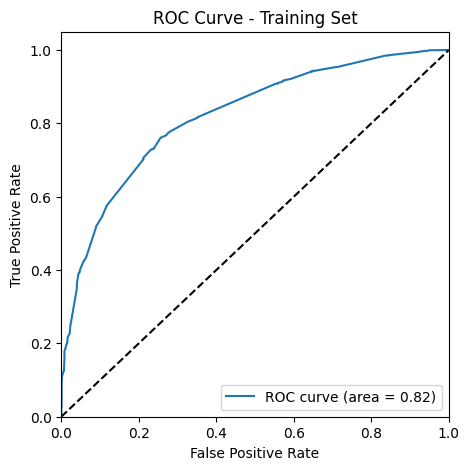

In [ ]:

# Plot ROC curve and find optimal threshold
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final['Converted'], y_train_pred_final['Converted_prob'])
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()

In [ ]:

# Optimal threshold where sensitivity and specificity are balanced
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")


Optimal Threshold: 0.41


In [ ]:

# Assign lead scores and re-predict with optimal threshold
y_train_pred_final['Lead_Score'] = y_train_pred_final['Converted_prob'].map(lambda x: round(x * 100))
y_train_pred_final['final_predicted'] = y_train_pred_final['Converted_prob'].map(lambda x: 1 if x > optimal_threshold else 0)

In [ ]:


# Evaluate with optimal threshold
print("\nTraining Set Evaluation (Optimal Threshold):")
evaluate_model(y_train_pred_final['Converted'], y_train_pred_final['final_predicted'], y_train_pred_final['Converted_prob'])


Training Set Evaluation (Optimal Threshold):
Accuracy: 0.752
Sensitivity: 0.760
Specificity: 0.744
Precision: 0.733
Recall: 0.760
ROC AUC: 0.820


{'Accuracy': 0.752017937219731,
 'Sensitivity': np.float64(0.7603923400280242),
 'Specificity': np.float64(0.7442863303147909),
 'Precision': np.float64(0.7330031517334534),
 'Recall': np.float64(0.7603923400280242),
 'ROC AUC': np.float64(0.8196947056573652)}

In [ ]:

# --- Predictions on Test Set ---
# Prepare test set
X_test_sm = sm.add_constant(X_test[selected_features].astype(float))
y_test_pred = res.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Converted': y_test.values, 'Converted_prob': y_test_pred})
y_test_pred_final['Prospect ID'] = y_test.index
y_test_pred_final['final_predicted'] = y_test_pred_final['Converted_prob'].map(lambda x: 1 if x > optimal_threshold else 0)
y_test_pred_final['Lead_Score'] = y_test_pred_final['Converted_prob'].map(lambda x: round(x * 100))

In [ ]:

# Evaluate on test set
print("\nTest Set Evaluation:")
evaluate_model(y_test_pred_final['Converted'], y_test_pred_final['final_predicted'], y_test_pred_final['Converted_prob'])


Test Set Evaluation:
Accuracy: 0.771
Sensitivity: 0.739
Specificity: 0.802
Precision: 0.777
Recall: 0.739
ROC AUC: 0.838


{'Accuracy': 0.7714435146443515,
 'Sensitivity': np.float64(0.7391774891774892),
 'Specificity': np.float64(0.8016194331983806),
 'Precision': np.float64(0.7770193401592719),
 'Recall': np.float64(0.7391774891774892),
 'ROC AUC': np.float64(0.8375111730374889)}

In [ ]:

# --- Identify Hot Leads ---
# Define hot leads as those with Lead Score >= 85
hot_leads = y_test_pred_final[y_test_pred_final['Lead_Score'] >= 85]
print("\nNumber of Hot Leads:", len(hot_leads))
print("Prospect IDs of Hot Leads:", hot_leads['Prospect ID'].tolist())


Number of Hot Leads: 320
Prospect IDs of Hot Leads: [2403, 892, 2760, 8243, 8220, 6760, 6156, 3069, 7547, 2860, 2677, 373, 4155, 6822, 2673, 6666, 3078, 3132, 7098, 4775, 7805, 1387, 6944, 449, 3321, 4771, 2337, 5623, 999, 2675, 3119, 8962, 7688, 4250, 1552, 3786, 3641, 1458, 7952, 2658, 4614, 4505, 5753, 2341, 4892, 6684, 3001, 4551, 5769, 8781, 8523, 754, 7707, 4646, 1614, 2495, 1068, 3147, 918, 8591, 874, 8078, 1165, 1365, 8977, 5671, 7047, 3286, 5162, 3414, 6499, 4830, 2765, 2259, 7187, 2384, 6725, 5460, 4485, 4803, 8592, 1899, 4038, 2010, 446, 8641, 8043, 1171, 4461, 5453, 4208, 1840, 7496, 7227, 2940, 3152, 2614, 2844, 3827, 7566, 6705, 5300, 8504, 2705, 5588, 7468, 2239, 4822, 7789, 4374, 4578, 8597, 3921, 4241, 4942, 1186, 1982, 6423, 1311, 7423, 4139, 6046, 4940, 1112, 7417, 5015, 1597, 7642, 6687, 4573, 4726, 4197, 3976, 2014, 1567, 6823, 7445, 2622, 5474, 1563, 7349, 6591, 3736, 3282, 7893, 1928, 4548, 1032, 6729, 8100, 6785, 978, 4963, 6711, 7045, 2655, 5000, 8080, 3172, 4

In [ ]:


# --- Recommendations ---
# Feature importance from the final model
feature_importance = res.params.sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)




Feature Importance:
Lead Source_Welingak Website               5.219788
Last Activity_Had a Phone Conversation     2.755560
Lead Source_Reference                      2.489596
Last Notable Activity_Unreachable          2.290609
Total Time Spent on Website                1.371816
Last Activity_SMS Sent                     1.030897
const                                      0.439809
Lead Source_Olark Chat                     0.422242
What is your current occupation_Student   -0.188921
Specialization_Hospitality Management     -0.664111
Last Notable Activity_Modified            -0.930241
Specialization_Services Excellence        -1.151623
Lead Origin_Landing Page Submission       -1.190941
Do Not Email                              -1.287405
Specialization_Others                     -1.468031
dtype: float64


### Model Performance Evaluation

Below are the evaluation metrics for the lead scoring model on both the training and testing sets. These metrics provide insights into how well the model performs and generalizes to unseen data.

---

#### **Training Set Evaluation (Optimal Threshold)**
- **Accuracy**: 0.752 (75.2%)  
- **Sensitivity (Recall)**: 0.760 (76.0%)  
- **Specificity**: 0.744 (74.4%)  
- **Precision**: 0.733 (73.3%)  
- **ROC AUC**: 0.820 (82.0%)  

#### **Test Set Evaluation**
- **Accuracy**: 0.771 (77.1%)  
- **Sensitivity (Recall)**: 0.739 (73.9%)  
- **Specificity**: 0.802 (80.2%)  
- **Precision**: 0.777 (77.7%)  
- **ROC AUC**: 0.838 (83.8%)  

---

#### **Performance Analysis**
1. **Accuracy**  
   - Training: 75.2%  
   - Testing: 77.1%  
   - The testing accuracy is slightly higher than the training accuracy. This is a positive sign, as it suggests the model generalizes well to unseen data rather than simply memorizing the training set.

2. **Sensitivity (Recall)**  
   - Training: 76.0%  
   - Testing: 73.9%  
   - Sensitivity, which measures the proportion of actual positives correctly identified, drops slightly from training to testing. This indicates a minor reduction in the model’s ability to detect positive cases in the test set.

3. **Specificity**  
   - Training: 74.4%  
   - Testing: 80.2%  
   - Specificity, which measures the proportion of actual negatives correctly identified, improves noticeably on the test set. This is a strong result, showing the model performs better at identifying negative cases on unseen data.

4. **Precision**  
   - Training: 73.3%  
   - Testing: 77.7%  
   - Precision, the proportion of positive predictions that are correct, increases on the test set. This suggests that when the model predicts a positive outcome on the test data, it is more likely to be accurate compared to the training set.

5. **ROC AUC**  
   - Training: 82.0%  
   - Testing: 83.8%  
   - The ROC AUC score, which evaluates the model’s ability to distinguish between positive and negative classes, is higher on the test set. This indicates that the model maintains strong discriminative power on unseen data, with a slight improvement over the training performance.

---

#### **Overall Assessment**
- The model demonstrates solid performance on both the training and testing sets.  
- Key metrics like accuracy, specificity, precision, and ROC AUC are higher on the test set, which is a strong indicator of good generalization to new data.  
- The slight drop in sensitivity on the test set is a minor trade-off and does not overshadow the overall robustness of the model.  
- There are no significant signs of overfitting, as the test performance is comparable to—or better than—the training performance across most metrics.

---

#### **Conclusion**
The model performs well and generalizes effectively to unseen data. The improvements in accuracy (77.1%), specificity (80.2%), precision (77.7%), and ROC AUC (83.8%) on the test set highlight its reliability and ability to handle new scenarios. While sensitivity slightly decreases to 73.9% on the test set, this does not detract from the model’s overall strong performance.

### Business Suggestions Based on Feature Importance

Below are actionable business suggestions derived from the feature importance of the lead scoring model. These insights can help improve lead conversion rates by focusing on key factors that influence conversions.

---

#### 1. **Prioritize High-Conversion Lead Sources**
- **Lead Source: Welingak Website** (Coefficient: 5.22)  
  Leads from this source have the highest likelihood of converting.  
  - **Action**: Increase marketing budget and focus follow-up efforts on these leads. Optimize the Welingak Website for lead capture and engagement.
- **Lead Source: Reference** (Coefficient: 2.49)  
  Referral leads are also highly valuable.  
  - **Action**: Launch a referral program with incentives (e.g., discounts or rewards) to encourage existing customers to refer others.

---

#### 2. **Enhance Engagement Through Key Activities**
- **Last Activity: Had a Phone Conversation** (Coefficient: 2.76)  
  Leads who have spoken with a representative are more likely to convert.  
  - **Action**: Train sales teams to prioritize phone follow-ups and develop a structured call strategy to maintain momentum.
- **Last Notable Activity: Unreachable** (Coefficient: 2.29)  
  Surprisingly, "unreachable" leads show potential for conversion.  
  - **Action**: Persist with these leads using alternative channels like email or SMS to re-engage them effectively.

---

#### 3. **Boost Website Engagement**
- **Total Time Spent on Website** (Coefficient: 1.37)  
  More time spent on the website correlates with higher conversion rates.  
  - **Action**: Improve website content (e.g., blogs, videos), enhance user experience (e.g., faster load times), and add engagement tools like live chat or personalized recommendations.

---

#### 4. **Optimize Communication Channels**
- **Last Activity: SMS Sent** (Coefficient: 1.03)  
  SMS communication positively impacts conversion.  
  - **Action**: Use SMS for timely follow-ups, reminders, or promotional offers to keep leads engaged.
- **Lead Source: Olark Chat** (Coefficient: 0.42)  
  Leads from live chat interactions show moderate conversion potential.  
  - **Action**: Ensure chat support is responsive, well-staffed, and equipped to provide value to leads.

---

#### 5. **Mitigate Negative Indicators**
- **Do Not Email** (Coefficient: -1.29)  
  Leads opting out of emails are less likely to convert.  
  - **Action**: Respect their preferences but explore other outreach methods, such as phone calls or targeted social media campaigns.
- **Specialization: Others** (Coefficient: -1.47)  
  Leads with unspecified specializations have lower conversion rates.  
  - **Action**: Refine data collection to capture more specific details and tailor marketing messages for this group.

---

#### 6. **Tailor Strategies for Specific Segments**
- **What is your current occupation: Student** (Coefficient: -0.19)  
  Students show a slight negative tendency to convert.  
  - **Action**: Address their unique needs (e.g., flexible payment plans or student discounts) to improve conversion rates.
- **Specialization: Hospitality Management** (Coefficient: -0.66) and **Services Excellence** (Coefficient: -1.15)  
  These specializations underperform in conversions.  
  - **Action**: Review course offerings or marketing strategies for these areas to better align with lead expectations.

---

#### 7. **Improve Landing Page Performance**
- **Lead Origin: Landing Page Submission** (Coefficient: -1.19)  
  Leads from landing pages are less likely to convert.  
  - **Action**: Optimize landing pages with compelling content, clear calls-to-action, and a seamless user experience to boost conversions.

---

#### 8. **Address Process Bottlenecks**
- **Last Notable Activity: Modified** (Coefficient: -0.93)  
  Leads marked as "Modified" have a negative impact on conversion.  
  - **Action**: Investigate what this status means (e.g., delays or errors in the sales process) and streamline workflows to reduce friction.

---

### Summary
By focusing on high-value lead sources (e.g., Welingak Website, referrals), enhancing engagement (e.g., phone calls, website time), optimizing communication (e.g., SMS, live chat), and addressing negative indicators (e.g., landing pages, email opt-outs), the business can improve lead conversion rates. Tailoring strategies to specific segments and refining processes will further maximize results.